In [1]:
import torch
import re
import logging
import numpy as np 
import random
import matplotlib.pyplot as plt

# from torch.nn.parallel import DistributedDataParallel as DDP
from functools import partial
from datasets import Dataset, load_dataset, concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    PreTrainedTokenizer,
    Trainer,
    TrainingArguments,
)
from torch.optim import AdamW, Adagrad

c:\Users\vmpletsos\Anaconda3\envs\guide\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_output_dir = './FineTunedDollyV2Test'

In [3]:
# To be added as special tokens
INSTRUCTION_KEY = "### Instruction:"
INPUT_KEY = "Input:"
RESPONSE_KEY = "### Response:"
END_KEY = "### End"
RESPONSE_KEY_NL = f"{RESPONSE_KEY}\n"

In [4]:
### name for model and tokenizer
# INPUT_MODEL = "gpt2-medium"
INPUT_MODEL = "databricks/dolly-v2-3b"

In [5]:
### Model Loading
def load_tokenizer(pretrained_model_name_or_path):
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
    # Make the pad token the same as end of string token
    tokenizer.pad_token = tokenizer.eos_token
    # Add the special tokens to the tokenizer
    tokenizer.add_special_tokens(
        {"additional_special_tokens": [END_KEY, INSTRUCTION_KEY, RESPONSE_KEY_NL, RESPONSE_KEY]}
    )
    return tokenizer

In [6]:
def load_model(pretrained_model_name_or_path):
    model = AutoModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path, 
        torch_dtype = torch.bfloat16,
        use_cache = False,
    )
    return model

In [7]:
def get_model_tokenizer(pretrained_model_name_or_path):
    tokenizer = load_tokenizer(pretrained_model_name_or_path)
    model = load_model(pretrained_model_name_or_path)
    model.resize_token_embeddings(len(tokenizer))
    return model, tokenizer

model, tokenizer = get_model_tokenizer(
    pretrained_model_name_or_path = INPUT_MODEL,
)

In [8]:
model = model.to("cuda")

In [9]:
# find max length in model configuration
conf = model.config
max_length = getattr(model.config, "max_position_embeddings", None)

In [10]:
# training prompt that does not contain an input string.
INTRO_BLURB = (
    "Below is an instruction that describes a task. Write a response that appropriately completes the request."
)

PROMPT_NO_INPUT_FORMAT = """{intro}

{instruction_key}
{instruction}

{response_key}
{response}

{end_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
    response="{response}",
    end_key=END_KEY,
)


# This is the prompt that is used for generating responses using an already trained model.  It ends with the response
# key, where the job of the model is to provide the completion that follows it (i.e. the response itself).
PROMPT_WITH_INPUT_FORMAT = """{intro}

{instruction_key}
{instruction}

{input_key}
{context}

{response_key}
{response}

{end_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    input_key=INPUT_KEY,
    context="{context}",
    response_key=RESPONSE_KEY,
    response="{response}",
    end_key=END_KEY
)



In [11]:
# Load the dataset but get first 1000 examples
dataset = load_dataset("databricks/databricks-dolly-15k")["train"].shuffle().select(range(300))
# load dataset from csv file
dataset2 = load_dataset("csv", data_files="LLM dataset train clean.csv")["train"]

Found cached dataset json (C:/Users/vmpletsos/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-7427aa6e57c34282/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
100%|██████████| 1/1 [00:00<00:00, 27.02it/s]
Found cached dataset csv (C:/Users/vmpletsos/.cache/huggingface/datasets/csv/default-f488882995b0868c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


In [12]:
instructions = dataset2['instruction']
contexts = dataset2['context']
responses = dataset2['response']

In [13]:
dataset = concatenate_datasets([dataset, dataset2])

In [14]:
def format_for_LLM(rec):
    instruction = rec["instruction"]
    instruction = "Answer the following question only with the provided input. If no answer is found tell that you cannot answer based on this context. " + instruction
    response = rec["response"]
    context = rec.get("context")
    if context:
        rec["text"] = PROMPT_WITH_INPUT_FORMAT.format(
            instruction=instruction, 
            response=response, 
            context=context
        )
    else:
        rec["text"] = PROMPT_NO_INPUT_FORMAT.format(
            instruction=instruction, 
            response=response
        )
    return rec

In [15]:
dataset = dataset.map(format_for_LLM)

In [16]:
dataset = dataset.shuffle()

In [17]:
def preprocess_batch(batch, tokenizer, max_length):
    return tokenizer(batch["text"], max_length=max_length, truncation=True)

In [18]:
preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)

In [19]:
dataset = dataset.map(
        preprocessing_function,
        batched=True,
        remove_columns=["instruction", "context", "response", "text", "category"],
    )

Map:   0%|          | 0/441 [00:00<?, ? examples/s]

In [20]:
# Make sure we don't have any truncated records, as this would mean the end keyword is missing.
dataset = dataset.filter(lambda rec: len(rec["input_ids"]) < max_length)
dataset = dataset.shuffle()

In [21]:
dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 441
})

In [22]:
# make parameters not trainable
for name, param in model.base_model.named_parameters():
    if not re.search(r"28|29|30|31", name):
        param.requires_grad = False
    else:
        # print(name)
        param.requires_grad = True
optimizer = AdamW(filter(lambda p: p.requires_grad, model.base_model.parameters()), lr=5e-6)

In [23]:
class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):
    def torch_call(self, examples):
        batch = super().torch_call(examples)

        # The prompt ends with the response key plus a newline
        response_token_ids = self.tokenizer.encode(RESPONSE_KEY_NL)
        labels = batch["labels"].clone()

        for i in range(len(examples)):
            response_token_ids_start_idx = None
            for idx in np.where(batch["labels"][i] == response_token_ids[0])[0]:
                response_token_ids_start_idx = idx
                break

            if response_token_ids_start_idx is None:
                raise RuntimeError(
                    f'Could not find response key {response_token_ids} in token IDs {batch["labels"][i]}'
                )

            response_token_ids_end_idx = response_token_ids_start_idx + 1

            # loss function ignore all tokens up through the end of the response key
            labels[i, :response_token_ids_end_idx] = -100

        batch["labels"] = labels

        return batch

In [24]:
data_collator = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False, return_tensors="pt", pad_to_multiple_of=8)

In [25]:
dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 441
})

In [26]:
training_args = TrainingArguments(
        output_dir=local_output_dir,
        per_device_train_batch_size=2,
        fp16=False,
        bf16=True,
        lr_scheduler_type='constant_with_warmup',
        num_train_epochs=20,
        deepspeed=None,
        gradient_accumulation_steps=16,
        gradient_checkpointing=False,
        logging_strategy="epoch",
        logging_steps=20,
        load_best_model_at_end=False,
        report_to=None,
        disable_tqdm=True,
        remove_unused_columns=False,
        warmup_steps=0,
    )

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    optimizers=(optimizer, None),
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

In [27]:
trainer.train()

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.6444, 'learning_rate': 5e-06, 'epoch': 0.94}
{'loss': 1.496, 'learning_rate': 5e-06, 'epoch': 1.95}
{'loss': 1.4014, 'learning_rate': 5e-06, 'epoch': 2.97}
{'loss': 1.3333, 'learning_rate': 5e-06, 'epoch': 3.98}
{'loss': 1.2903, 'learning_rate': 5e-06, 'epoch': 5.0}
{'loss': 1.3247, 'learning_rate': 5e-06, 'epoch': 5.94}
{'loss': 1.1865, 'learning_rate': 5e-06, 'epoch': 6.95}
{'loss': 1.1495, 'learning_rate': 5e-06, 'epoch': 7.96}
{'loss': 1.1373, 'learning_rate': 5e-06, 'epoch': 8.98}
{'loss': 1.1341, 'learning_rate': 5e-06, 'epoch': 9.99}
{'loss': 1.1728, 'learning_rate': 5e-06, 'epoch': 10.93}
{'loss': 1.0911, 'learning_rate': 5e-06, 'epoch': 11.95}
{'loss': 1.0716, 'learning_rate': 5e-06, 'epoch': 12.96}
{'loss': 1.0862, 'learning_rate': 5e-06, 'epoch': 13.97}
{'loss': 1.0327, 'learning_rate': 5e-06, 'epoch': 14.99}
{'loss': 1.0847, 'learning_rate': 5e-06, 'epoch': 16.0}
{'loss': 1.1189, 'learning_rate': 5e-06, 'epoch': 16.94}
{'loss': 1.0395, 'learning_rate': 5e-06, 'ep

TrainOutput(global_step=260, training_loss=1.1983592950380766, metrics={'train_runtime': 3575.3837, 'train_samples_per_second': 2.467, 'train_steps_per_second': 0.073, 'train_loss': 1.1983592950380766, 'epoch': 18.82})

In [35]:
# get all loss and eval loss from trainer history if loss is not None
losses = [x['loss'] for x in trainer.state.log_history if 'loss' in x.keys()]

Text(0, 0.5, 'Loss')

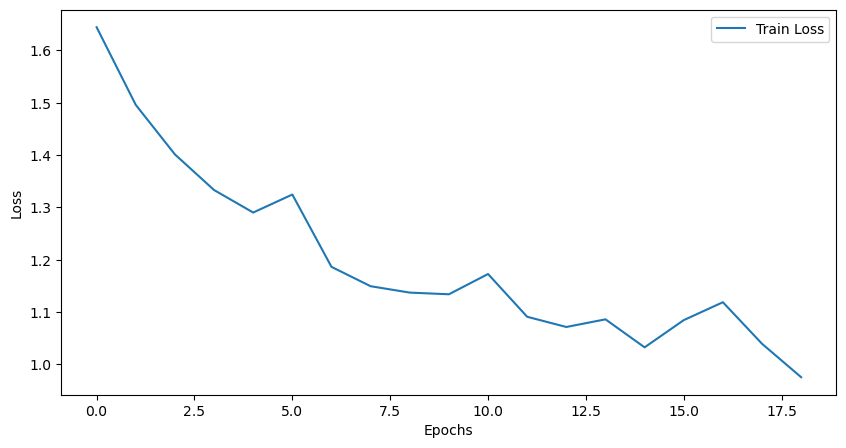

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.legend(['Train Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Test the trained model

In [37]:
# # Load the pretrained model and tokenizer
# tokenizer = tokenizer = AutoTokenizer.from_pretrained(local_output_dir)
# model = model = AutoModelForCausalLM.from_pretrained(
#     local_output_dir, 
#     torch_dtype = torch.bfloat16,
# );
# model.resize_token_embeddings(len(tokenizer));
# model = model.to("cuda");

In [38]:
PROMPT_FOR_GENERATION_FORMAT = """{intro}

{instruction_key}
{instruction}

{response_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
)


# This is the prompt that is used for generating responses using an already trained model.  It ends with the response
# key, where the job of the model is to provide the completion that follows it (i.e. the response itself).
PROMPT_FOR_GENERATION_FORMAT_WITH_INPUT = """{intro}

{instruction_key}
{instruction}

{input_key}
{context}

{response_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    input_key=INPUT_KEY,
    context="{context}",
    response_key=RESPONSE_KEY,
)

In [39]:
def get_special_token_id(tokenizer: PreTrainedTokenizer, key: str) -> int:
    """Gets the token ID for a given string that has been added to the tokenizer as a special token.
    When training, we configure the tokenizer so that the sequences like "### Instruction:" and "### End" are
    treated specially and converted to a single, new token.  This retrieves the token ID each of these keys map to.
    Args:
        tokenizer (PreTrainedTokenizer): the tokenizer
        key (str): the key to convert to a single token
    Raises:
        RuntimeError: if more than one ID was generated
    Returns:
        int: the token ID for the given key
    """
    token_ids = tokenizer.encode(key)
    if len(token_ids) > 1:
        raise ValueError(f"Expected only a single token for '{key}' but found {token_ids}")
    return token_ids[0]

def preprocess(tokenizer, instruction_text, context_text=None):
    instruction = "Answer the following question only with the provided input. If no answer is found tell that you cannot answer based on this context. " + instruction_text
    if context_text:
        prompt_text = PROMPT_FOR_GENERATION_FORMAT_WITH_INPUT.format(instruction=instruction, context=context_text)
    else:
        prompt_text = PROMPT_FOR_GENERATION_FORMAT.format(instruction=instruction)
    print(prompt_text)
    inputs = tokenizer(prompt_text, return_tensors="pt",)
    inputs["prompt_text"] = prompt_text
    inputs["instruction_text"] = instruction_text
    inputs["context_text"] = context_text
    return inputs

def forward(model, tokenizer, model_inputs, max_length=256):
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs.get("attention_mask", None)

    if input_ids.shape[1] == 0:
        input_ids = None
        attention_mask = None
        in_b = 1
    else:
        in_b = input_ids.shape[0]

    generated_sequence = model.generate(
        input_ids=input_ids.to(model.device),
        attention_mask=attention_mask.to(model.device),
        pad_token_id=tokenizer.pad_token_id,
        max_length=max_length
    )

    out_b = generated_sequence.shape[0]
    generated_sequence = generated_sequence.reshape(in_b, out_b // in_b, *generated_sequence.shape[1:])
    instruction_text = model_inputs.pop("instruction_text", None)

    return {
        "generated_sequence": generated_sequence, 
        "input_ids": input_ids,
    }


def postprocess(tokenizer, model_outputs):
    response_key_token_id = get_special_token_id(tokenizer, RESPONSE_KEY_NL)
    end_key_token_id = get_special_token_id(tokenizer, END_KEY)
    generated_sequence = model_outputs["generated_sequence"][0]
    
    # send it to cpu
    generated_sequence = generated_sequence.cpu()
    generated_sequence = generated_sequence.numpy().tolist()
    records = []

    for sequence in generated_sequence:
        decoded = None

        try:
            response_pos = sequence.index(response_key_token_id)
        except ValueError:
            print(f"Could not find response key {response_key_token_id} in: {sequence}")
            response_pos = None

        if response_pos:
            try:
                end_pos = sequence.index(end_key_token_id)
            except ValueError:
                print("Could not find end key, the output is truncated!")
                end_pos = None
            decoded = tokenizer.decode(sequence[response_pos + 1 : end_pos], skip_special_tokens=True).strip()
            
        if not decoded:
            # Otherwise we'll decode everything and use a regex to find the response and end.

            fully_decoded = tokenizer.decode(sequence)
            # The response appears after "### Response:".  The model has been trained to append "### End" at the
            # end.
            m = re.search(r"#+\s*Response:\s*(.+?)#+\s*End", fully_decoded, flags=re.DOTALL)
            if m:
                decoded = m.group(1).strip()
            else:
                # The model might not generate the "### End" sequence before reaching the max tokens.  In this case,
                # return everything after "### Response:".
                m = re.search(r"#+\s*Response:\s*(.+)", fully_decoded, flags=re.DOTALL)
                if m:
                    decoded = m.group(1).strip()
                else:
                    print(f"Failed to find response in:\n{fully_decoded}")
            
            
        rec = {"generated_text": decoded}
        records.append(rec)
    return records

In [40]:
i = 17
text = instructions[i]
context = contexts[i]
actual_response = responses[i]
pre_process_result = preprocess(tokenizer, text, context)
model_result = forward(model, tokenizer, pre_process_result)
final_output = postprocess(tokenizer, model_result);
print('LLM response: ', final_output[0]['generated_text'])
print('Actual response: ', actual_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer the following question only with the provided input. If no answer is found tell that you cannot answer based on this context. What are the n semiconductors?

Input:
after a long research project, conducted in the laboratory of material science and engineering by prof. t. skoulikidis, a material based on n semiconductors was advanced. these are metal oxides that acquire semiconducting properties when prepared electrolytically

### Response:

LLM response:  The n semiconductors are metal oxides that acquire semiconducting properties when prepared electrolytically.
Actual response:  Metal oxides that acquire semiconducting properties when prepared electrolytically.


In [41]:
trainer.save_model(output_dir=local_output_dir);
tokenizer.save_pretrained(local_output_dir);